In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import cv2
from tqdm import tqdm
import itertools

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
# from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.image as img

import os 
import pathlib 

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

2024-06-04 13:30:58.467581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 13:30:58.467727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 13:30:58.722328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# train_df = pd.read_csv('/kaggle/input/trashcan-2/train_df.csv')
# val_df = pd.read_csv('/kaggle/input/trashcan-2/val_df.csv')
# test_df = pd.read_csv('/kaggle/input/trashcan-2/test_df.csv')

In [8]:
# Mendefinisikan struktur folder, label utama, dan label tambahan
categories = ['Anorganik', 'B3', 'Organik']
additional_labels = {
    'Anorganik': ['bungkus_makanan', 'HDPEM', 'kaca', 'kaleng', 'PET', 'plastic_shopping_bag', 'rag'],
    'B3': ['aerosol_cans', 'battery', 'glass_cosmetics_containers', 'medicine_bottle', 'plastic_detergent_bottles', 'tablet_capsule'],
    'Organik': ['daun', 'eggshells', 'food_waste', 'kardus', 'kertas', 'tissue']
}

# Get all files from the main directory
main_directory = "/kaggle/input/trashcan-3/dataset-trashcan"
all_files = []
for root, dirs, files in os.walk(main_directory):
    for file in files:
        file_path = os.path.join(root, file)  # Full path to the file
        relative_file_path = os.path.relpath(file_path, main_directory)
        labels = {category: 0 for category in categories}
        additional_label_values = {label: 0 for label in additional_labels['Anorganik'] + additional_labels['B3'] + additional_labels['Organik']}
        
        # Set main label values
        for i, category in enumerate(categories):
            if category in relative_file_path:
                labels[category] = 1
        
        # Set additional label values
        for key, value in additional_labels.items():
            for label in value:
                if label in relative_file_path:
                    additional_label_values[label] = 1
        
        all_files.append({'file_name': file_path, **labels, **additional_label_values})

# Create DataFrame
df = pd.DataFrame(all_files)

In [9]:
df

,file_name,Anorganik,B3,Organik,bungkus_makanan,HDPEM,kaca,kaleng,PET,plastic_shopping_bag,...,glass_cosmetics_containers,medicine_bottle,plastic_detergent_bottles,tablet_capsule,daun,eggshells,food_waste,kardus,kertas,tissue
0,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15966,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15967,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15968,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15969,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
from sklearn.model_selection import train_test_split

# Initialize empty DataFrames for train, validation, and test sets
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

main_labels = ['Anorganik', 'B3', 'Organik']

# Split the data for each main label category
for label in main_labels:
    label_df = df[df[label] == 1]
    train, test = train_test_split(label_df, test_size=0.15, random_state=42)
    train, val = train_test_split(train, test_size=0.15, random_state=42)
    
    train_df = pd.concat([train_df, train])
    val_df = pd.concat([val_df, val])
    test_df = pd.concat([test_df, test])

In [11]:
train_df

,file_name,Anorganik,B3,Organik,bungkus_makanan,HDPEM,kaca,kaleng,PET,plastic_shopping_bag,...,glass_cosmetics_containers,medicine_bottle,plastic_detergent_bottles,tablet_capsule,daun,eggshells,food_waste,kardus,kertas,tissue
1867,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5284,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2672,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3051,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4903,/kaggle/input/trashcan-3/dataset-trashcan/Anor...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13301,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14636,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13639,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10599,/kaggle/input/trashcan-3/dataset-trashcan/Orga...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Define the labels
main_categories = ['Anorganik', 'B3', 'Organik']
anorganik_subcategories = ['bungkus_makanan', 'HDPEM', 'kaca', 'kaleng', 'PET', 'plastic_shopping_bag', 'rag']
b3_subcategories = ['aerosol_cans', 'battery', 'glass_cosmetics_containers', 'medicine_bottle', 'plastic_detergent_bottles', 'tablet_capsule']
organik_subcategories = ['daun', 'eggshells', 'food_waste', 'kardus', 'kertas', 'tissue']

all_labels = main_categories + anorganik_subcategories + b3_subcategories + organik_subcategories

# Function to extract labels
def extract_labels(row):
    labels = []
    if row['Anorganik'] == 1:
        labels.append('Anorganik')
        for subcategory in anorganik_subcategories:
            if row[subcategory] == 1:
                labels.append(subcategory)
    elif row['B3'] == 1:
        labels.append('B3')
        for subcategory in b3_subcategories:
            if row[subcategory] == 1:
                labels.append(subcategory)
    else:
        labels.append('Organik')
        for subcategory in organik_subcategories:
            if row[subcategory] == 1:
                labels.append(subcategory)
    return labels

train_labels = train_df.apply(extract_labels, axis=1)
val_labels = val_df.apply(extract_labels, axis=1)
test_labels = test_df.apply(extract_labels, axis=1)

mlb = MultiLabelBinarizer(classes=all_labels)
mlb.fit(train_labels)

train_labels = mlb.transform(train_labels)
val_labels = mlb.transform(val_labels)
test_labels = mlb.transform(test_labels)

In [13]:
train_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [14]:
# Function to preprocess images
def preprocess_image(file_path, labels):
    # Read the image from file
    image = tf.io.read_file(file_path)
    # Decode the image, automatically handling different formats
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Ensure the image has a static shape for resizing
    image.set_shape([None, None, 3])
    # Resize the image to 224x224 pixels
    image = tf.image.resize_with_pad(image, 128, 128)
    # Normalize the image to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    return image, labels

# Convert DataFrame to TensorFlow Dataset
def dataframe_to_dataset(df, labels):
    file_paths = df['file_name'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = dataframe_to_dataset(train_df, train_labels)

# Configure the dataset for performance
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Function to preprocess images
def valtest_preprocess_image(file_path, labels):
    # Read the image from file
    image = tf.io.read_file(file_path)
    # Decode the image, automatically handling different formats
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Ensure the image has a static shape for resizing
    image.set_shape([None, None, 3])
    # Resize the image to 224x224 pixels
    image = tf.image.resize_with_pad(image, 128, 128)
    # Normalize the image to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, labels

# Convert DataFrame to TensorFlow Dataset
def valtest_dataframe_to_dataset(df, labels):
    file_paths = df['file_name'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: valtest_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create datasets
val_dataset = valtest_dataframe_to_dataset(val_df, val_labels)
test_dataset = valtest_dataframe_to_dataset(test_df, test_labels)

# Configure the dataset for performance
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
# Building the model with EfficientNetB3
def create_model():
#     base_model = tf.keras.applications.EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
#     base_model = tf.keras.applications.VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add custom layers
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    # Output layer for multi-label classification
    outputs = tf.keras.layers.Dense(len(all_labels), activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,574,102 (116.63 MB)

 Trainable params: 6,986,390 (26.65 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # watch the val loss metric
    patience=10,  # if val loss doesn't improve for 10 epochs, stop training
    restore_best_weights=True  # restore the best weights
)

In [34]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[lr_callback, early_stopping]
)

Epoch 1/100
  3/361 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.1007 - loss: 0.7093     

W0000 00:00:1717510164.091790     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8943 - loss: 0.1286

W0000 00:00:1717510206.647825     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717510210.896452     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717510218.671419     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


361/361 ━━━━━━━━━━━━━━━━━━━━ 79s 152ms/step - accuracy: 0.8942 - loss: 0.1285 - val_accuracy: 0.4340 - val_loss: 0.4913 - learning_rate: 0.0010
Epoch 2/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.8645 - loss: 0.1087 - val_accuracy: 0.4119 - val_loss: 0.3955 - learning_rate: 0.0010
Epoch 3/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.8737 - loss: 0.0846 - val_accuracy: 0.5538 - val_loss: 0.2530 - learning_rate: 0.0010
Epoch 4/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.8791 - loss: 0.0699 - val_accuracy: 0.5223 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 5/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.8691 - loss: 0.0677 - val_accuracy: 0.4379 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 6/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.8637 - loss: 0.0619 - val_accuracy: 0.5444 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 7/100
361/361 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.8793 - loss:

In [35]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.7667 - loss: 0.0962
Test Loss: 0.0790
Test Accuracy: 81.47%


W0000 00:00:1717511643.553775     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 7/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

W0000 00:00:1717511758.725457     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step


W0000 00:00:1717511766.148998     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


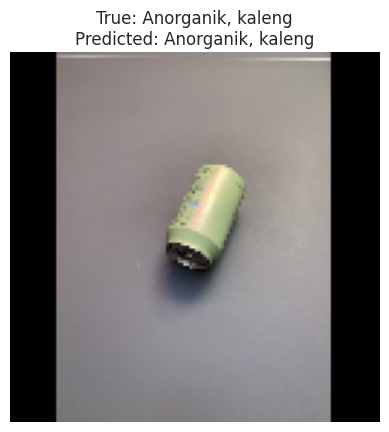

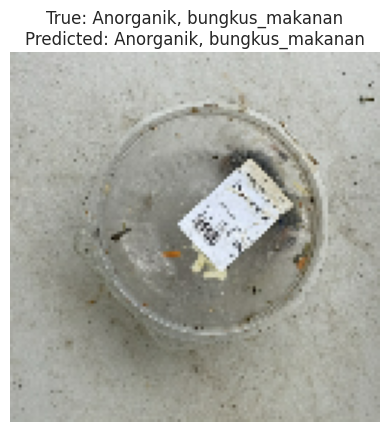

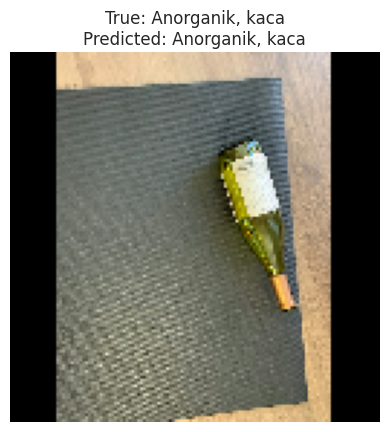

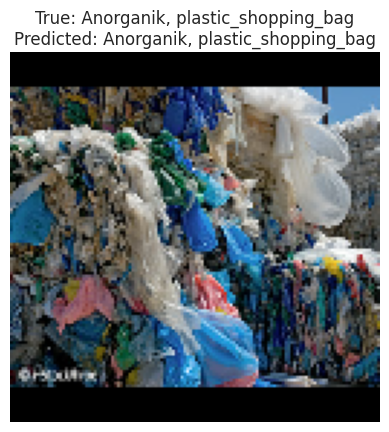

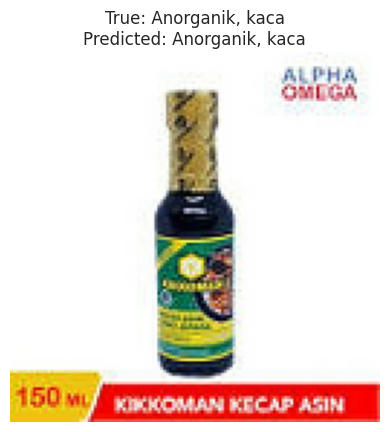

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test dataset
predictions = model.predict(test_dataset)

# Threshold predictions to get binary values
binary_predictions = (predictions >= 0.5).astype(int)

# Convert predictions and true labels back to label names
inverse_predictions = mlb.inverse_transform(binary_predictions)
inverse_true_labels = mlb.inverse_transform(test_labels)

# Display some test images with their true and predicted labels
def display_image(image, true_label, predicted_label):
    # Normalize image values to be between 0 and 1 if they are not already
    if np.max(image) > 1:
        image = image / 255.0
    plt.imshow(image)
    plt.title(f"True: {', '.join(true_label)}\nPredicted: {', '.join(predicted_label)}")
    plt.axis('off')
    plt.show()

# Get test dataset without batching for display
test_images = []
test_true_labels = []
for image, label in test_dataset.unbatch().take(5):
    test_images.append(image.numpy())
    test_true_labels.append(label.numpy())

# Display first 5 test images with true and predicted labels
for i in range(5):
    display_image(test_images[i], inverse_true_labels[i], inverse_predictions[i])

In [30]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import tensorflow as tf

def download_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content))
            img.verify()  # Verify that it's an actual image
            img = Image.open(BytesIO(response.content))  # Reopen after verification
            return img
        except (IOError, SyntaxError) as e:
            print(f"Error opening image: {e}")
            return None
    else:
        print(f"Failed to download image. HTTP status code: {response.status_code}")
        return None

# Function to preprocess the image
def preprocess_image(img, target_size):
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to predict the label of an image from URL
def predict_image_from_url(url, model, mlb, target_size=(128, 128)):
    img = download_image(url)
    if img is not None:
        preprocessed_img = preprocess_image(img, target_size)
        prediction = model.predict(preprocessed_img)
        
        print(f"Raw prediction: {prediction}")  # Debug statement
        
        binary_prediction = (prediction > 0.5).astype(int)
        
        print(f"Binary prediction: {binary_prediction}")  # Debug statement
        
        inverse_prediction = mlb.inverse_transform(binary_prediction)
        
        print(f"Inverse prediction: {inverse_prediction}")  # Debug statement
        
        return img, inverse_prediction
    else:
        print("Could not process the image.")
        return None, None

# URL of the image to predict
image_url = "https://akcdn.detik.net.id/community/media/visual/2017/07/28/5ecdf93c-1b1d-4fe6-a120-4a68909f3982_169.jpg?w=700&q=90"

# Predict the label for the image from URL
image, predicted_label = predict_image_from_url(image_url, model, mlb)

if image is not None and predicted_label is not None:
    image.show()
    print(f"Predicted label: {predicted_label}")
else:
    print("Prediction failed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Raw prediction: [[1.86896473e-01 7.33660981e-02 8.27766657e-01 6.54250756e-02
  2.11477596e-02 6.42507300e-02 8.63494650e-02 2.49709208e-02
  4.28022742e-02 1.08707726e-01 2.80294823e-03 5.77746220e-02
  2.70315970e-04 1.59993768e-02 2.71005929e-03 3.69375199e-02
  2.85742227e-02 6.15589414e-03 3.13002691e-02 1.69287063e-02
  7.79423177e-01 1.16172731e-01]]
Binary prediction: [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
Inverse prediction: [('Organik', 'kertas')]
Predicted label: [('Organik', 'kertas')]


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening '/tmp/tmp08c_xmev.PNG'
